<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>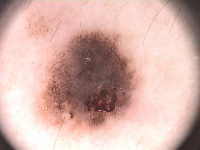</td><td>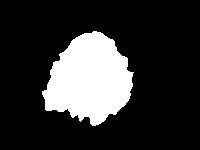</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
!ls

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

<h3 style="text-align: center;"><b>Степанюк Денис Борисович</b></h3>
<h3 style="text-align: center;"><b>https://t.me/SDBproduction</b></h3>

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

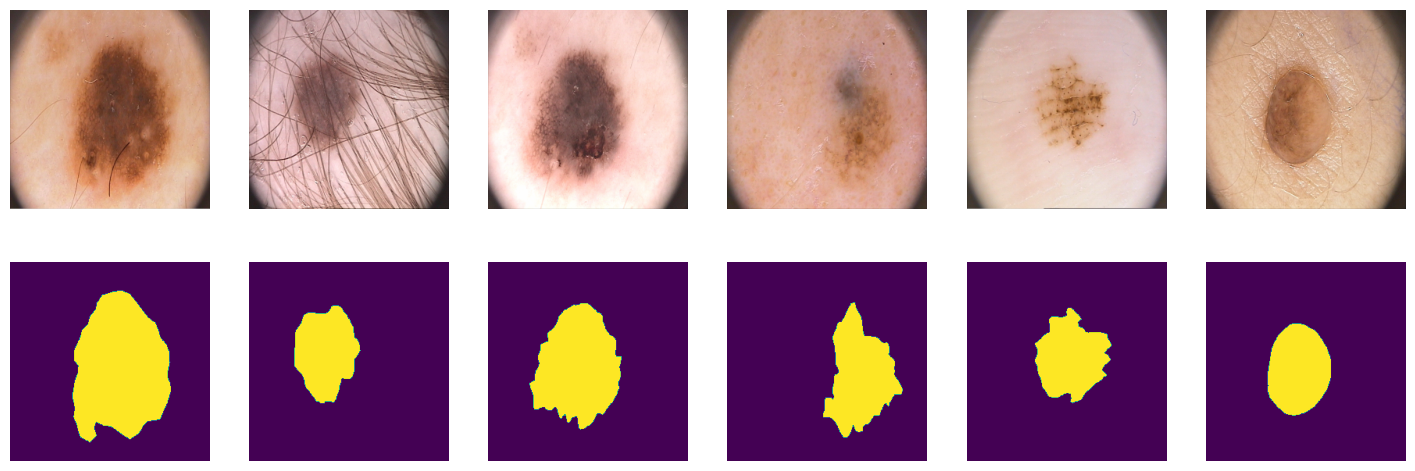

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [34]:
print(len(tr), len(val), len(ts))
print(type(tr), type(val), type(ts))
print(tr.shape, val.shape, ts.shape)

print(len(X), len(X[tr]))
print(type(X), type(X[tr]))
print(X.shape, X[tr].shape)

xsc = []
xsc = np.rollaxis(X, 3, 1)

print(len(xsc))
print(type(xsc))
print(xsc.shape)

100 50 50
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(100,) (50,) (50,)
200 100
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(200, 256, 256, 3) (100, 256, 256, 3)
200
<class 'numpy.ndarray'>
(200, 3, 256, 256)


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [35]:
data_tr

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

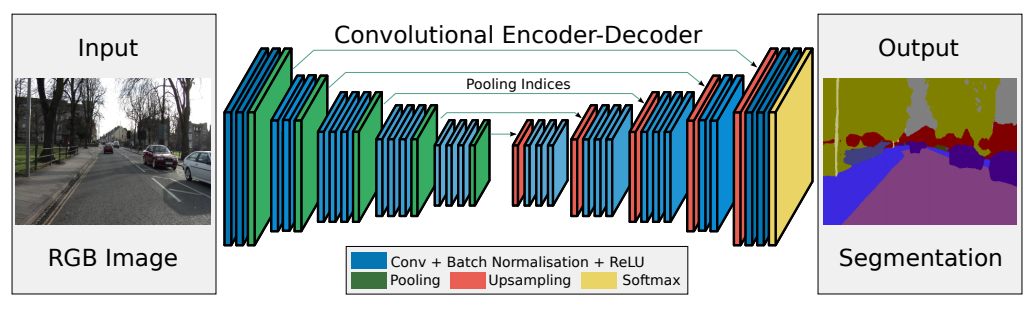

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm), )
        
        # 1-й Sequential
        self.enc_conv0 = nn.Sequential( 
                            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU()) 
        
        # 1-й MaxPool2d
#         self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 256 -> 128
        self.pool0 = nn.MaxPool2d(2, return_indices=True)  # 256 -> 128
        # 2-й Sequential
        self.enc_conv1 = nn.Sequential( 
                            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU()) 
        
        # 2-й MaxPool2d
#         self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        # 3-й Sequential
        self.enc_conv2 = nn.Sequential( 
                            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU()) 
        # 3-й MaxPool2d
#         self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        # 4-й Sequential
        self.enc_conv3 = nn.Sequential( 
                            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU()) 
        # 4-й MaxPool2d
#         self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True) # 32 -> 16
        self.pool3 = nn.MaxPool2d(2, return_indices=True)
    
    
        # bottleneck - В этой архитектуре не использовал, реализацию можно посмотреть дальше в UNET и UNET2.
#         self.bottleneck_conv =


        # decoder (upsampling) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # 1-й MaxUnpool2d
#         self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.upsample0 = nn.MaxUnpool2d(2)
        self.dec_conv0 = nn.Sequential( 
                            nn.Conv2d(512, 512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(512, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU())
            
        
        # 2-й MaxUnpool2d
#         self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.upsample1 = nn.MaxUnpool2d(2)
        self.dec_conv1 = nn.Sequential( 
                            nn.Conv2d(256, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(256, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU())
        
        
        # 3-й MaxUnpool2d
#         self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.upsample2 = nn.MaxUnpool2d(2)
        self.dec_conv2 = nn.Sequential( 
                            nn.Conv2d(128, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(128, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU())
        
        # 4-й MaxUnpool2d
#         self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.upsample3 = nn.MaxUnpool2d(2) 
        self.dec_conv3 = nn.Sequential( 
                            nn.Conv2d(64, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(64, 1, kernel_size=3, padding=1),
#                             nn.Sigmoid()
#                             nn.BatchNorm2d(1, momentum=0.5)
                            )
        
        

    def forward(self, x):
        # encoder
        e0, ind_e0 = self.pool0(self.enc_conv0(x))
        e0_size = x.size()
        
        e1, ind_e1 = self.pool1(self.enc_conv1(e0))
        e1_size = e0.size()
        
        e2, ind_e2 = self.pool2(self.enc_conv2(e1))
        e2_size = e1.size()
        
        e3, ind_e3 = self.pool3(self.enc_conv3(e2))
#         print('e3 :', e3)
        e3_size = e2.size()
#         e3_sizee3_size.view(
        #flatten Images
#         x = x.view(x.size(0), -1)


        # bottleneck
#         b =

        # decoder
        d0_up = self.upsample0(e3, ind_e3, output_size=e3_size)
        d0 = self.dec_conv0(d0_up)
        
        d1_up =self.upsample1(d0, ind_e2, output_size=e2_size)
        d1 = self.dec_conv1(d1_up)
        
        d2_up =self.upsample2(d1, ind_e1, output_size=e1_size)
        d2 = self.dec_conv2(d2_up)
        
        d3_up = self.upsample3(d2, ind_e0, output_size=e0_size)
        d3 = self.dec_conv3(d3_up)  # no activation
#         return torch.nn.functional.softmax(d3, dim=1)
        return d3
    
    
# https://github.com/vinceecws/SegNet_PyTorch/blob/master/CamVid/SegNet.py
# https://russianblogs.com/article/16901527933/

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_real, y_pred):
    
    Loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    
    return Loss  

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    Loss_Valid = [] # ! внесённые изменения
    Loss_Train = [] # ! внесённые изменения
    Score_Valid = [] # ! внесённые изменения
#     DEVICE = torch.device("cuda")
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device, работаем на видеокарте
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results, detach and put into cpu.
        model.eval()  # testing mode

        with torch.set_grad_enabled(False):
            Y_hat = model(X_val.to(device)).cpu()
            loss_val = loss_fn(Y_val, Y_hat) # ! внесённые изменения


#         Оценка модели каждую эпоху
        score_val = score_model(model, iou_pytorch, data_val)

        # Visualize tools
        activation_fn = nn.Sigmoid()
        
        Score_Valid.append(score_val) # ! внесённые изменения
        Loss_Valid.append(loss_val) # ! внесённые изменения
        Loss_Train.append(loss) # ! внесённые изменения
        
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(4, 10, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(4, 10, k+11)
            with torch.set_grad_enabled(False):
                Y_pred = activation_fn(Y_pred) 
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
#         //////////////
            plt.subplot(4, 10, k+6)
            plt.imshow(np.rollaxis(X_batch[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Train dataset')
            plt.axis('off')

            plt.subplot(4, 10, k+16)
            with torch.set_grad_enabled(False):
                Y_pred = activation_fn(Y_pred)  
            plt.imshow(Y_pred[k, 0].detach().cpu().numpy(), cmap='gray')
            plt.title('Output train')
            plt.axis('off')
#         /////////////////
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    
        
        plt.figure(figsize=(8, 4))
        plt.plot(torch.tensor(Loss_Train, device = 'cpu'), label="train_loss")
        plt.plot(torch.tensor(Loss_Valid, device = 'cpu'), label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
        
        
        
        plt.figure(figsize=(8, 4))
        plt.plot(torch.tensor(Score_Valid, device = 'cpu'), label="Score Validation")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("score")
        plt.show()
        
    return Score_Valid, Loss_Valid, Loss_Train

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [17]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [18]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    activation_fn = nn.Sigmoid()
    for X_batch, Y_label in data:

        Y_pred = model(X_batch.to(device))
        
        Y_pred = torch.clamp(Y_pred, min=0, max=1)

        scores += metric(Y_pred.cpu(), Y_label.cpu()).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [19]:
model = SegNet().to(device)

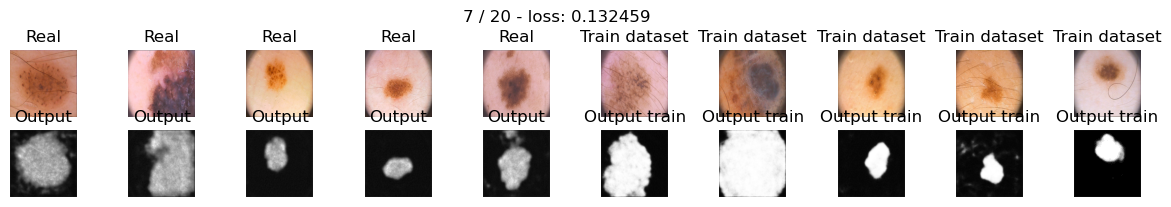

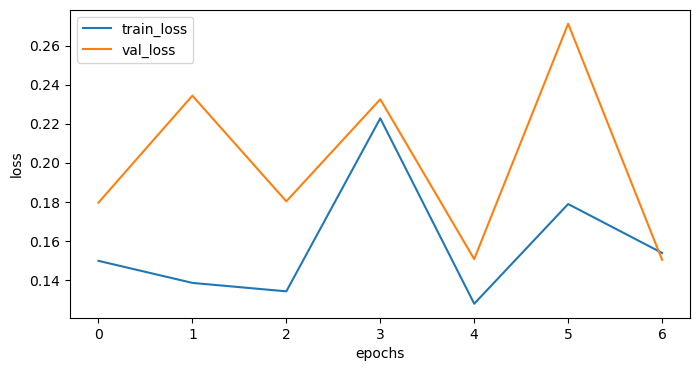

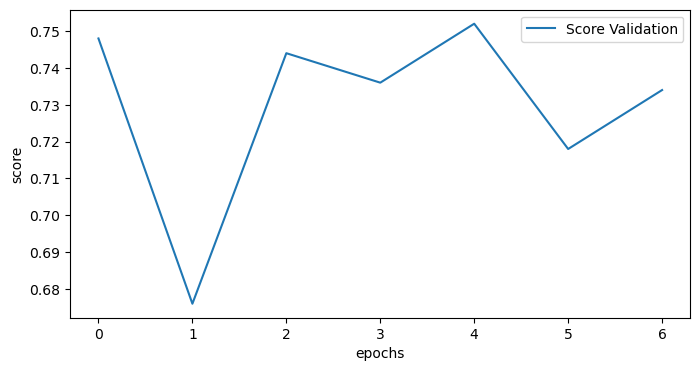

* Epoch 8/20
loss: 0.126487


KeyboardInterrupt: 

In [22]:
max_epochs = 20
 
optim = torch.optim.Adam(model.parameters(), lr=3e-5)

SV_m1_bce, LV_m1_bce, LT_m1_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [21]:
score_model(model, iou_pytorch, data_val)
# print('SV_m1_bce: ', SV_m1_bce)
# print('LV_m1_bce: ', LV_m1_bce)
# print('LT_m1_bce: ', LT_m1_bce)

0.7280000209808349

Ответьте себе на вопрос: не переобучается ли моя модель?


<h3><b>Переобучается, на графике ближе к концу видно как трейн и валид лоссы начинают расходится, а скор падает. </b></h3>

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [20]:
def dice_loss(y_real, y_pred):  
#     Кол-во картинок
    N = y_real.size(0)
    
#     Разворачиваем картинки в вектора
    y_pred_flat = y_pred.view(N, -1)
    y_real_flat = y_real.view(N, -1)
    
#     Пересечение масок
    intersection = torch.sum(y_real * y_pred, dim=1)
    
#     Союз масок
    union = torch.sum(y_real + y_pred - y_real * y_pred, dim=1)
    
    dice_coef = (2*intersection)/union
    
    L_dice = 1 - (1/(256*256)) * dice_coef
    
#     print((L_dice.sum() / N))
    return (L_dice.sum() / N)


# https://russianblogs.com/article/81481218661/

Проводим тестирование:

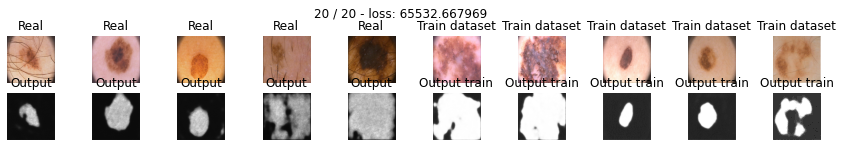

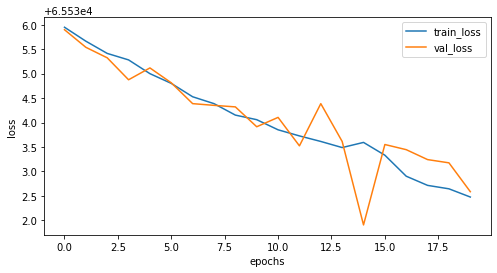

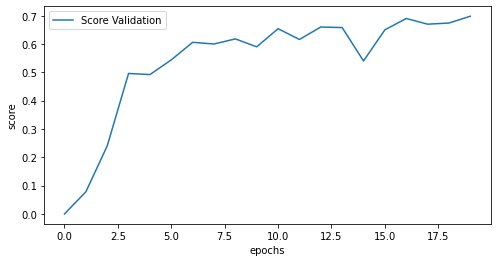

In [21]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-5)
SV_m2_dice, LV_m2_dice, LT_m2_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [22]:
score_model(model_dice, iou_pytorch, data_val)

0.6980000019073487

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [23]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):   
    y_pred = y_pred.sigmoid()
    bce = bce_loss(y_real, y_pred)
    alpha = y_real * eps + (1. - y_real) * (1. - eps)
    pt = torch.where(y_real == 1, y_pred, 1 - y_pred)
    L_focal = alpha * (1. - pt) ** gamma * bce
    return L_focal.mean()

# https://www.youtube.com/watch?v=Y8_OVwK4ECk&list=LL&index=1&t=752s

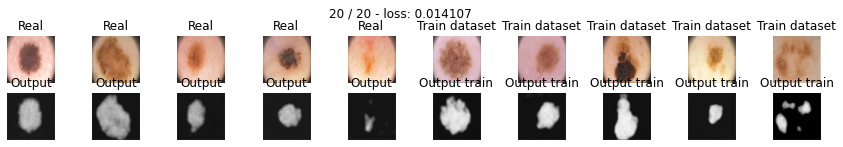

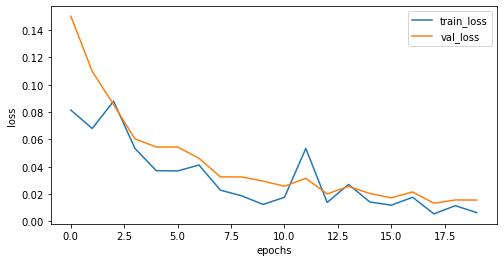

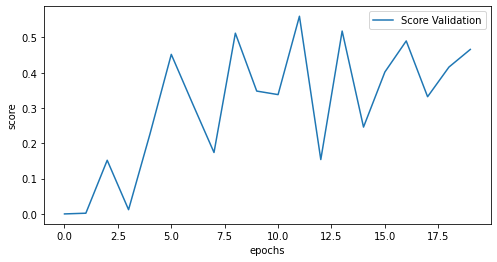

In [24]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=3e-5)
SV_m3_focal, LV_m3_focal, LT_m3_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [25]:
score_model(model_focal, iou_pytorch, data_val)

0.46599999666213987

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [26]:
# Soft Targets (ST)

# Hard target - строго 0 и 1. Классификатор никогда не сможет достичь этих значений в предсказаниях, 
# он всегда будет выдавать приближённые значения (0,993...).

# Soft target - поэтому мы 'размываем' целевую переменную которую нам надо предсказать, 
# то есть вместо 1 нам надо предсказать например 0,99547. 

# В коде мы можем поиграть с smooth_factor чтобы посмотреть какое 'рамытие' целевой переменной какой даёт результат.

# В теории hard target повышает риск переобучить модель, а soft target в свою очередь должна понизить риск переобучения.


# Total Variation Loss (TVL)

# Думаю очевидно что наши предсказания содержат в себе некий процент шумов и было бы не плохо избавиться от шума.
# Для этого можно посчитать TVL, чем больше шума тем выше значения TVL, далее через бэкпропагатион будем понижать TVL,
# тем самым понижая кол-во шумов.


def bce_ST_TVL_Loss(y_real, y_pred):
    
#     Размываем целевую переменную.
    smooth_factor = 0.08
    y_real = (1 - y_real) * smooth_factor + y_real * (1 - smooth_factor)
    
    
#     Расчитываем Total Variation Loss (TVL).
    TVLoss_weight=1
    batch_size, c_img, h_img, w_img = y_pred.size()
    
    tv_h = torch.pow(y_pred[:,:,1:,:]-y_pred[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(y_pred[:,:,:,1:]-y_pred[:,:,:,:-1], 2).sum()
    
    TVL = TVLoss_weight*(tv_h+tv_w)/(batch_size*c_img*h_img*w_img)
    
    
    bce_loss_Soft_Targets = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
       
    return bce_loss_Soft_Targets + TVL


# Soft Targets:
# http://www.iapr-tc11.org/archive/icfhr2008/Proceedings/papers/cr1009.pdf
# https://smp.readthedocs.io/en/latest/_modules/segmentation_models_pytorch/losses/soft_bce.html
# https://github.com/pytorch/pytorch/issues/11959

# Total Variation Loss (TVL):
# https://github.com/bnsreenu/python_for_microscopists
# https://discuss.pytorch.org/t/implement-total-variation-loss-in-pytorch/55574
# https://github.com/jxgu1016/Total_Variation_Loss.pytorch/blob/master/TVLoss.py
# https://torchmetrics.readthedocs.io/en/stable/image/total_variation.html
# https://www.programmersought.com/article/92305825222/ - вывод

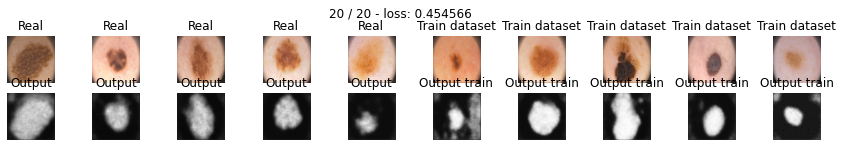

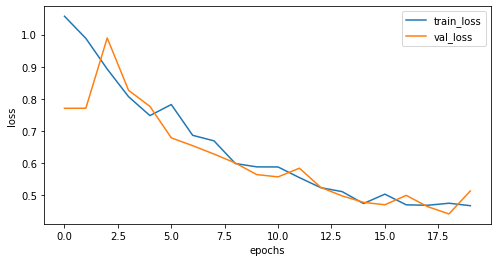

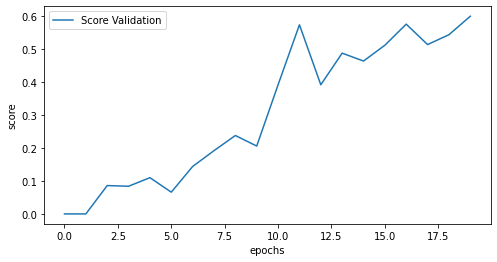

In [63]:
model_TVLoss = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_TVLoss.parameters(), lr=3e-5)
SV_m4_ST_TVL, LV_m4_ST_TVL, LT_m4_ST_TVL = train(model_TVLoss, optimaizer, bce_ST_TVL_Loss, max_epochs, data_tr, data_val)

In [30]:
score_model(model_TVLoss, iou_pytorch, data_val)

0.45599998235702516

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

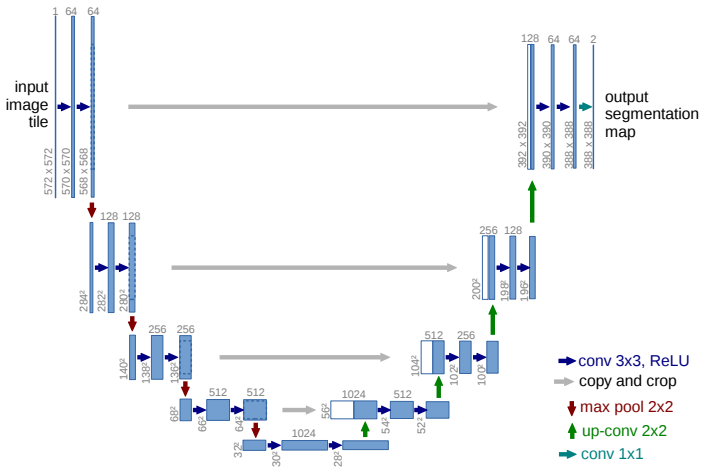

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [31]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        # 1-й Down Sequential
        self.enc_conv0 = nn.Sequential( 
                            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU()
        
        )
        # 1-й MaxPool2d
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True) # 256 -> 128
        
        # 2-й Down Sequential
        self.enc_conv1 = nn.Sequential( 
                            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 2-й MaxPool2d
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64
        
        # 3-й Down Sequential
        self.enc_conv2 = nn.Sequential( 
                            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 3-й MaxPool2d
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32
        
        # 4-й Down Sequential
        self.enc_conv3 = nn.Sequential( 
                            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 4-й MaxPool2d
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 32 -> 16

        
        
        
        
        # bottleneck - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.bottleneck_conv = nn.Sequential( 
                            nn.Conv2d(512, 1024, kernel_size=1),  # in_channels, out_channels
                            nn.BatchNorm2d(1024, momentum=0.5),
                            nn.ReLU(),
                            
                                        
                            nn.Conv2d(1024, 512, kernel_size=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU() 
        )
        # bottleneck - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    
    

        # decoder (upsampling)
        
        # 1-й MaxUnpool2d
        self.upsample0 = nn.MaxUnpool2d(2) # 16 -> 32
        # 1-й Up Sequential
        self.dec_conv0 = nn.Sequential( 
                            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(512, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU())

        
        # 2-й MaxUnpool2d
        self.upsample1 = nn.MaxUnpool2d(2) # 32 -> 64
        # 2-й Up Sequential
        self.dec_conv1 = nn.Sequential( 
                            nn.Conv2d(512, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(256, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU())
        
        # 3-й MaxUnpool2d
        self.upsample2 = nn.MaxUnpool2d(2)  # 64 -> 128
        # 3-й Up Sequential
        self.dec_conv2 = nn.Sequential( 
                            nn.Conv2d(256, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(128, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU())
        
        # 4-й MaxUnpool2d
        self.upsample3 = nn.MaxUnpool2d(2) # 128 -> 256
        # 4-й Up Sequential
        self.dec_conv3 =  nn.Sequential( 
                            nn.Conv2d(128, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(64, 1, kernel_size=3, padding=1))

    def forward(self, x):
        # encoder
        # 1-й Down Sequential и MaxPool2d
        e0_d3 = self.enc_conv0(x)
        e0, ind_e0 = self.pool0(e0_d3)
        e0_size = x.size()
        
        # 2-й Down Sequential и MaxPool2d
        e1_d2 = self.enc_conv1(e0)
        e1, ind_e1 = self.pool1(e1_d2)
        e1_size = e0.size()
        
        # 3-й Down Sequential и MaxPool2d
        e2_d1 = self.enc_conv2(e1)
        e2, ind_e2 = self.pool2(e2_d1)
        e2_size = e1.size()
        
        # 4-й Down Sequential и MaxPool2d
        e3_d0 = self.enc_conv3(e2)
        e3, ind_e3 = self.pool3(e3_d0)
        e3_size = e2.size()

        # bottleneck
        b = self.bottleneck_conv(e3)

        
        # decoder
        # 1-й MaxUnpool2d и Up Sequential   
        d0_up = self.upsample0(b, ind_e3, output_size=e3_size)
        
#         print('d0_up size: ', d0_up.size())
# #         print('d0_up: ', d0_up)
#         print('e3_d0.size(): ', e3_d0.size())
# #         print('e3_d0: ', e3_d0)
#         print('torch.cat((d0_up, e3_d0), 0).size(): ', torch.cat((d0_up, e3_d0), 1).size())
# #         print('torch.cat((d0_up, e3_d0), 0): ', torch.cat((d0_up, e3_d0), 0))

        d0 = self.dec_conv0(torch.cat((d0_up, e3_d0), 1))
        
        # 2-й MaxUnpool2d и Up Sequential
        d1_up =self.upsample1(d0, ind_e2, output_size=e2_size)
        d1 = self.dec_conv1(torch.cat((d1_up, e2_d1), 1))

        
        # 3-й MaxUnpool2d и Up Sequential
        d2_up =self.upsample2(d1, ind_e1, output_size=e1_size)
        d2 = self.dec_conv2(torch.cat((d2_up, e1_d2), 1))

        
        # 4-й MaxUnpool2d и Up Sequential
        d3_up = self.upsample3(d2, ind_e0, output_size=e0_size)
        d3 = self.dec_conv3(torch.cat((d3_up, e0_d3), 1))  # no activation  # no activation
        return d3

In [32]:
unet_model = UNet().to(device)

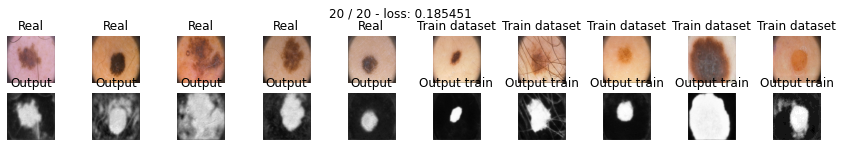

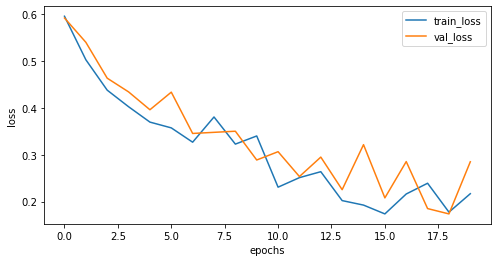

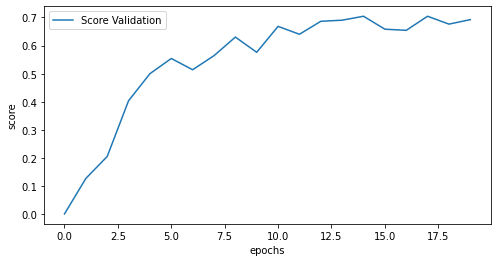

In [33]:
SV_U_bce, LV_U_bce, LT_U_bce = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=3e-5), bce_loss, 20, data_tr, data_val)

In [34]:
score_model(unet_model, iou_pytorch, data_val)

0.6920000076293945

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [35]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        # 1-й Down Sequential
        self.enc_conv0 = nn.Sequential( 
                            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU()
        
        )
        # 1-й MaxPool2d
        self.pool0 = nn.MaxPool2d(3, stride=2, padding=1, return_indices=True) # 256 -> 128
         
        # 2-й Down Sequential
        self.enc_conv1 = nn.Sequential( 
                            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 2-й MaxPool2d
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1, return_indices=True) # 128 -> 64
        
        # 3-й Down Sequential
        self.enc_conv2 = nn.Sequential( 
                            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 3-й MaxPool2d
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=1, return_indices=True) # 64 -> 32
        
        # 4-й Down Sequential
        self.enc_conv3 = nn.Sequential( 
                            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
            
                            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU()      
        
        )
        # 4-й MaxPool2d
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=1, return_indices=True)  # 32 -> 16

        
        
        
        
        # bottleneck - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.bottleneck_conv = nn.Sequential( 
                            nn.Conv2d(512, 1024, kernel_size=1),  # in_channels, out_channels
                            nn.BatchNorm2d(1024, momentum=0.5),
                            nn.ReLU(),
                            
                                        
                            nn.Conv2d(1024, 512, kernel_size=1),  # in_channels, out_channels
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU() 
        )
        # bottleneck - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    
    
        # decoder (upsampling)
        
        # 1-й Upsample(32)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        # 1-й Up Sequential
        self.dec_conv0 = nn.Sequential( 
                            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                            nn.BatchNorm2d(512, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(512, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU())

        
        # 2-й nn.Upsample(32)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        # 2-й Up Sequential
        self.dec_conv1 = nn.Sequential( 
                            nn.Conv2d(512, 256, kernel_size=3, padding=1),
                            nn.BatchNorm2d(256, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(256, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU())
        
        # 3-й nn.Upsample(32)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # 64 -> 128
        # 3-й Up Sequential
        self.dec_conv2 = nn.Sequential( 
                            nn.Conv2d(256, 128, kernel_size=3, padding=1),
                            nn.BatchNorm2d(128, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(128, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU())
        
        # 4-й nn.Upsample(32)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest') # 128 -> 256
        # 4-й Up Sequential
        self.dec_conv3 =  nn.Sequential( 
                            nn.Conv2d(128, 64, kernel_size=3, padding=1),
                            nn.BatchNorm2d(64, momentum=0.5),
                            nn.ReLU(),
                            
                            nn.Conv2d(64, 1, kernel_size=3, padding=1))


    def forward(self, x):
        # encoder
        # 1-й Down Sequential и MaxPool2d
        e0_d3 = self.enc_conv0(x)
        e0, ind_e0 = self.pool0(e0_d3)
        e0_size = x.size()
        
        # 2-й Down Sequential и MaxPool2d
        e1_d2 = self.enc_conv1(e0)
        e1, ind_e1 = self.pool1(e1_d2)
        e1_size = e0.size()
        
        # 3-й Down Sequential и MaxPool2d
        e2_d1 = self.enc_conv2(e1)
        e2, ind_e2 = self.pool2(e2_d1)
        e2_size = e1.size()
        
        # 4-й Down Sequential и MaxPool2d
        e3_d0 = self.enc_conv3(e2)
        e3, ind_e3 = self.pool3(e3_d0)
        e3_size = e2.size()

        # bottleneck
        b = self.bottleneck_conv(e3)

        
        # decoder
        # 1-й MaxUnpool2d и Up Sequential   
        d0_up = self.upsample0(b)
        
#         print('d0_up size: ', d0_up.size())
# #         print('d0_up: ', d0_up)
#         print('e3_d0.size(): ', e3_d0.size())
# #         print('e3_d0: ', e3_d0)
#         print('torch.cat((d0_up, e3_d0), 0).size(): ', torch.cat((d0_up, e3_d0), 1).size())
# #         print('torch.cat((d0_up, e3_d0), 0): ', torch.cat((d0_up, e3_d0), 0))

        d0 = self.dec_conv0(torch.cat((d0_up, e3_d0), 1))
        
        # 2-й MaxUnpool2d и Up Sequential
        d1_up =self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1_up, e2_d1), 1))

        
        # 3-й MaxUnpool2d и Up Sequential
        d2_up =self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2_up, e1_d2), 1))

        
        # 4-й MaxUnpool2d и Up Sequential
        d3_up = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3_up, e0_d3), 1))  # no activation  # no activation
        return d3

In [36]:
unet2_model = UNet2().to(device)


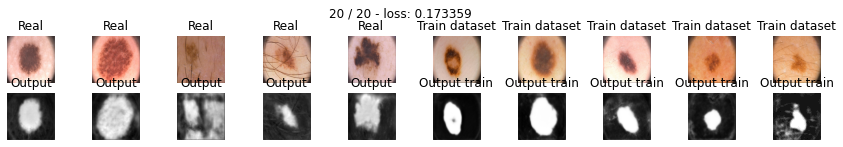

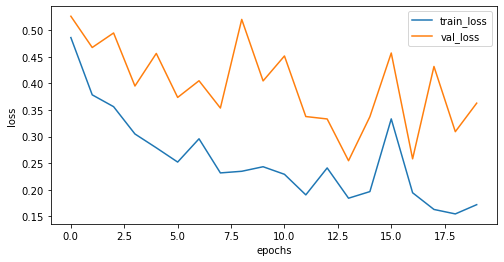

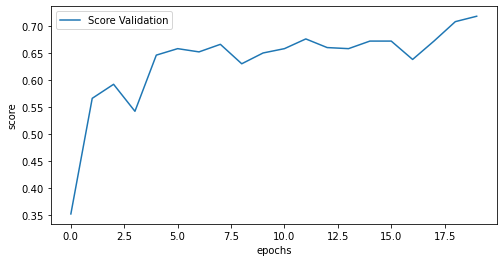

In [37]:
SV_U2_bce, LV_U2_bce, LT_U2_bce = train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=3e-5), bce_loss, 20, data_tr, data_val)

In [38]:
score_model(unet2_model, iou_pytorch, data_val)

0.7180000066757202

Сделайте вывод, какая из моделей лучше

<h3><b>Лучший результат показала UNet2. </b></h3>

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [ ]:
# Выше я реализовал 3 модели с разной структурой (SegNet, UNet, UNet2).
# Все модели были обучены на 20 эпохах, оптимизатор Adam c заданым lr=3e-5,
# функция потерь bce_loss. 

# При прочих равных видим что лучший результат показала UNet2. Видно что в целом структура UNet
# даёт результат лучший чем SegNet из чего делаем вывод что скипконекшн работает.

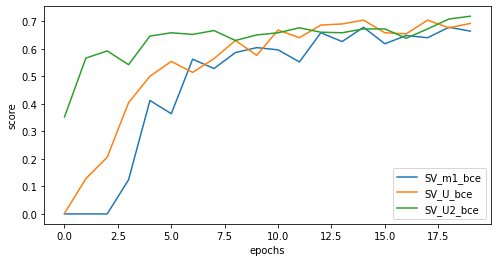

In [64]:
plt.figure(figsize=(8, 4))

plt.plot(torch.tensor(SV_m1_bce, device = 'cpu'), label="SV_m1_bce")
plt.plot(torch.tensor(SV_U_bce, device = 'cpu'), label="SV_U_bce")
plt.plot(torch.tensor(SV_U2_bce, device = 'cpu'), label="SV_U2_bce")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
# Выше я реализовал 4 функции потерь (bce_loss, dice_loss, focal_loss, bce_ST_TVL_Loss).

# Иницилизировал 4 модели со структурой SegNet, все модели были обучены на 20 эпохах, 
# оптимизатор Adam c заданым lr=3e-5 и разными функциями потерь. 

# При прочих равных видим что лучший результат показала dice_loss. Видно что от выбранной функции потерь
# очень сильно зависит конечный результат, поэтому желательно пробовать разные варианты чтобы получить лучший результат.

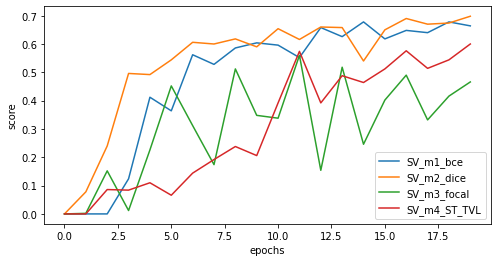

In [65]:
plt.figure(figsize=(8, 4))

plt.plot(torch.tensor(SV_m1_bce, device = 'cpu'), label="SV_m1_bce")
plt.plot(torch.tensor(SV_m2_dice, device = 'cpu'), label="SV_m2_dice")
plt.plot(torch.tensor(SV_m3_focal, device = 'cpu'), label="SV_m3_focal")
plt.plot(torch.tensor(SV_m4_ST_TVL, device = 'cpu'), label="SV_m4_ST_TVL")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
# Так как по факту было обучено 6 моделей, выведем всю информацию на одном графике для наглядности.

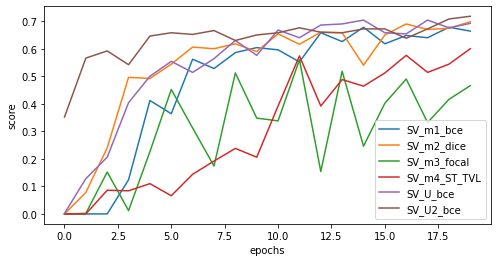

In [66]:
plt.figure(figsize=(8, 4))

plt.plot(torch.tensor(SV_m1_bce, device = 'cpu'), label="SV_m1_bce")
plt.plot(torch.tensor(SV_m2_dice, device = 'cpu'), label="SV_m2_dice")
plt.plot(torch.tensor(SV_m3_focal, device = 'cpu'), label="SV_m3_focal")
plt.plot(torch.tensor(SV_m4_ST_TVL, device = 'cpu'), label="SV_m4_ST_TVL")
plt.plot(torch.tensor(SV_U_bce, device = 'cpu'), label="SV_U_bce")
plt.plot(torch.tensor(SV_U2_bce, device = 'cpu'), label="SV_U2_bce")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [60]:
# Вывожу score для 6 моделей для каждой эпохи обучения(validation dataset).

# Видно что лучше всего себя показала модель UNet2 на 20 эпохе с результатом 0.718.
# Худший результат m3_focal на 20 эпохе с результатом 0.466.
# Средний результат:
# 0.664 + 0.698 + 0.466 + 0.6 + 0.692 + 0.718 = 3.838
# 3.838 ÷ 6 = 0.639(6)

In [77]:
import pandas as pd
# fig, ax = plt.subplots()
history = []
history.append(SV_m1_bce)
history.append(SV_m2_dice)
history.append(SV_m3_focal)
history.append(SV_m4_ST_TVL)
history.append(SV_U_bce)
history.append(SV_U2_bce)

pd.DataFrame(data=history, index=["m1_bce", "m2_dice", "m3_focal","m4_ST_TVL", "U_bce", "U2_bce"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
m1_bce,0.000,0.000,0.000,0.124,0.412,0.364,0.562,0.528,0.586,0.604,0.596,0.552,0.658,0.626,0.678,0.618,0.648,0.640,0.678,0.664
m2_dice,0.000,0.078,0.240,0.496,0.492,0.544,0.606,0.600,0.618,0.590,0.654,0.616,0.660,0.658,0.540,0.650,0.690,0.670,0.674,0.698
m3_focal,0.000,0.002,0.152,0.012,0.226,0.452,0.312,0.174,0.512,0.348,0.338,0.560,0.154,0.518,0.246,0.402,0.490,0.332,0.416,0.466
m4_ST_TVL,0.000,0.000,0.086,0.084,0.110,0.066,0.144,0.192,0.238,0.206,0.392,0.574,0.392,0.488,0.464,0.512,0.576,0.514,0.544,0.600
U_bce,0.002,0.128,0.206,0.404,0.500,0.554,0.514,0.564,0.630,0.576,0.668,0.640,0.686,0.690,0.704,0.658,0.654,0.704,0.676,0.692
U2_bce,0.352,0.566,0.592,0.542,0.646,0.658,0.652,0.666,0.630,0.650,0.658,0.676,0.660,0.658,0.672,0.672,0.638,0.672,0.708,0.718


In [ ]:
# Так как каждая функция loss измеряет ошибку в собственном диапозоне значений, то нет
# смысла сравнивать значения функций loss.

# Но если наложить графики функций loss друг на друга, то можно приблизительно увидеть как
# учаться модели друг относительно друга. Видно на какой эпохе какая модель начинает переобучатся,
# где loss быстрей сходится, где он сходится плавно, а где рывками.

# Так как loss dice у меня измеряется в диапозоне от 65535.8984 до 65532.5859, а остальные
# в диапозоне от 0 до 1, то dice вывожу на одтельном графике.

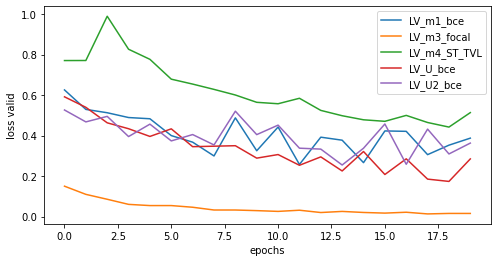

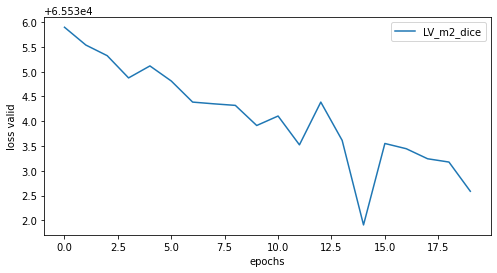

In [68]:
plt.figure(figsize=(8, 4))

plt.plot(LV_m1_bce, label="LV_m1_bce")
# plt.plot(LV_m2_dice, label="LV_m2_dice") # 65535.8984 - 65532.5859
plt.plot(LV_m3_focal, label="LV_m3_focal")
plt.plot(LV_m4_ST_TVL, label="LV_m4_ST_TVL")
plt.plot(LV_U_bce, label="LV_U_bce")
plt.plot(LV_U2_bce, label="LV_U2_bce")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss valid")
plt.show()


plt.figure(figsize=(8, 4))

plt.plot(LV_m2_dice, label="LV_m2_dice") # 65535.8984 - 65532.5859

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss valid")
plt.show()

In [ ]:
# SV_m1_bce, LV_m1_bce, LT_m1_bce
# SV_m2_dice, LV_m2_dice, LT_m2_dice
# SV_m3_focal, LV_m3_focal, LT_m3_focal
# SV_m4_ST_TVL, LV_m4_ST_TVL, LT_m4_ST_TVL 
# SV_U_bce, LV_U_bce, LT_U_bce
# SV_U2_bce, LV_U2_bce, LT_U2_bce